In [65]:
import scanpy as sc
import torch
import scarches as sca
import pandas as pd
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.6.0'

### prepare reference dataset

In [3]:
ensg_to_symbol = pd.read_csv("gene.bed", sep="\t", names=["chr", "start", "stop", "ensg", "symbol"])
gene_lengths = pd.read_csv("gene_lengths_human.bed", sep="\t")
gene_lengths = gene_lengths.merge(ensg_to_symbol, left_on="gene", right_on="ensg", how='left')

In [4]:
adata = sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Maynard_Bivona_2020_NSCLC/output_adata.h5ad")

In [5]:
gene_intersection = set(gene_lengths["symbol"].drop_duplicates(keep=False)) & set(adata.var_names.drop_duplicates(keep=False))

In [6]:
adata2 = adata[:, list(gene_intersection)].copy()

In [7]:
gene_length_factor = gene_lengths.set_index("symbol").loc[adata2.var_names,"mean"].values

In [8]:
adata2.layers["counts"] = adata2.layers["raw_counts"] @ sp.diags(1/gene_length_factor)

In [9]:
adata = adata2

In [10]:
sc.pp.log1p(adata)
adata.raw = adata

In [11]:
annotations = pd.read_csv("maynard_annotations.csv").set_index("Run")
adata.obs["cell_type"] = annotations.loc[adata.obs.index.values, "cell_type"]

In [12]:
source_adata = adata

### prepare query dataset

In [14]:
adata = sc.read_h5ad("../../data/20_qc_norm_scrnaseq/01_qc_and_filtering/Lambrechts_2018_LUAD_6653/output_adata.h5ad")

In [15]:
adata.layers["counts"] = adata.X.copy()

In [16]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

In [17]:
target_adata = adata

In [18]:
annotations = pd.read_csv("lambrechts_annotations.csv").set_index("index")
adata.obs["original_cell_type"] = annotations.loc[adata.obs.index.values, "cell_type"]

### subset to common genes

In [19]:
common_genes = list(set(source_adata.var_names) & set(target_adata.var_names))

In [20]:
source_adata = source_adata[:, common_genes].copy()
target_adata = target_adata[:, common_genes].copy()

## Train model on query dataset

In [22]:
sca.dataset.setup_anndata(source_adata, batch_key="sample", labels_key="cell_type", layer="counts")

INFO     Using batches from adata.obs["sample"]                                              
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              


/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scvi/data/_anndata.py:793: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


INFO     Successfully registered anndata object containing 17124 cells, 17974 vars, 44       
         batches, 11 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [23]:
vae = sca.models.SCANVI(
    source_adata,
    "Unknown",
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


In [24]:
vae_epochs = 500
scanvi_epochs = 200
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_scanvi = {
    "early_stopping_metric": "accuracy",
    "save_best_state_metric": "accuracy",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [25]:
vae.train(
    n_epochs_unsupervised=vae_epochs,
    n_epochs_semisupervised=scanvi_epochs,
    unsupervised_trainer_kwargs=dict(early_stopping_kwargs=early_stopping_kwargs),
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["elbo", "accuracy"],
                                       early_stopping_kwargs=early_stopping_kwargs_scanvi),
    frequency=1
)



INFO     Training Unsupervised Trainer for 500 epochs.                                       
INFO     Training SemiSupervised Trainer for 200 epochs.                                     


/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scvi/core/distributions/_negative_binomial.py:432: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


INFO     KL warmup for 400 epochs                                                            
Training...:  36%|███▌      | 181/500 [11:18<19:57,  3.75s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  36%|███▌      | 181/500 [11:22<20:02,  3.77s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  391 s. / 500 epochs                                                 
INFO     KL warmup phase exceeds overall training phaseIf your applications rely on the      
         posterior quality, c

In [26]:
reference_latent = sc.AnnData(vae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs["cell_type"].tolist()
reference_latent.obs["batch"] = source_adata.obs["patient"].tolist()



WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


... storing 'cell_type' as categorical
... storing 'batch' as categorical


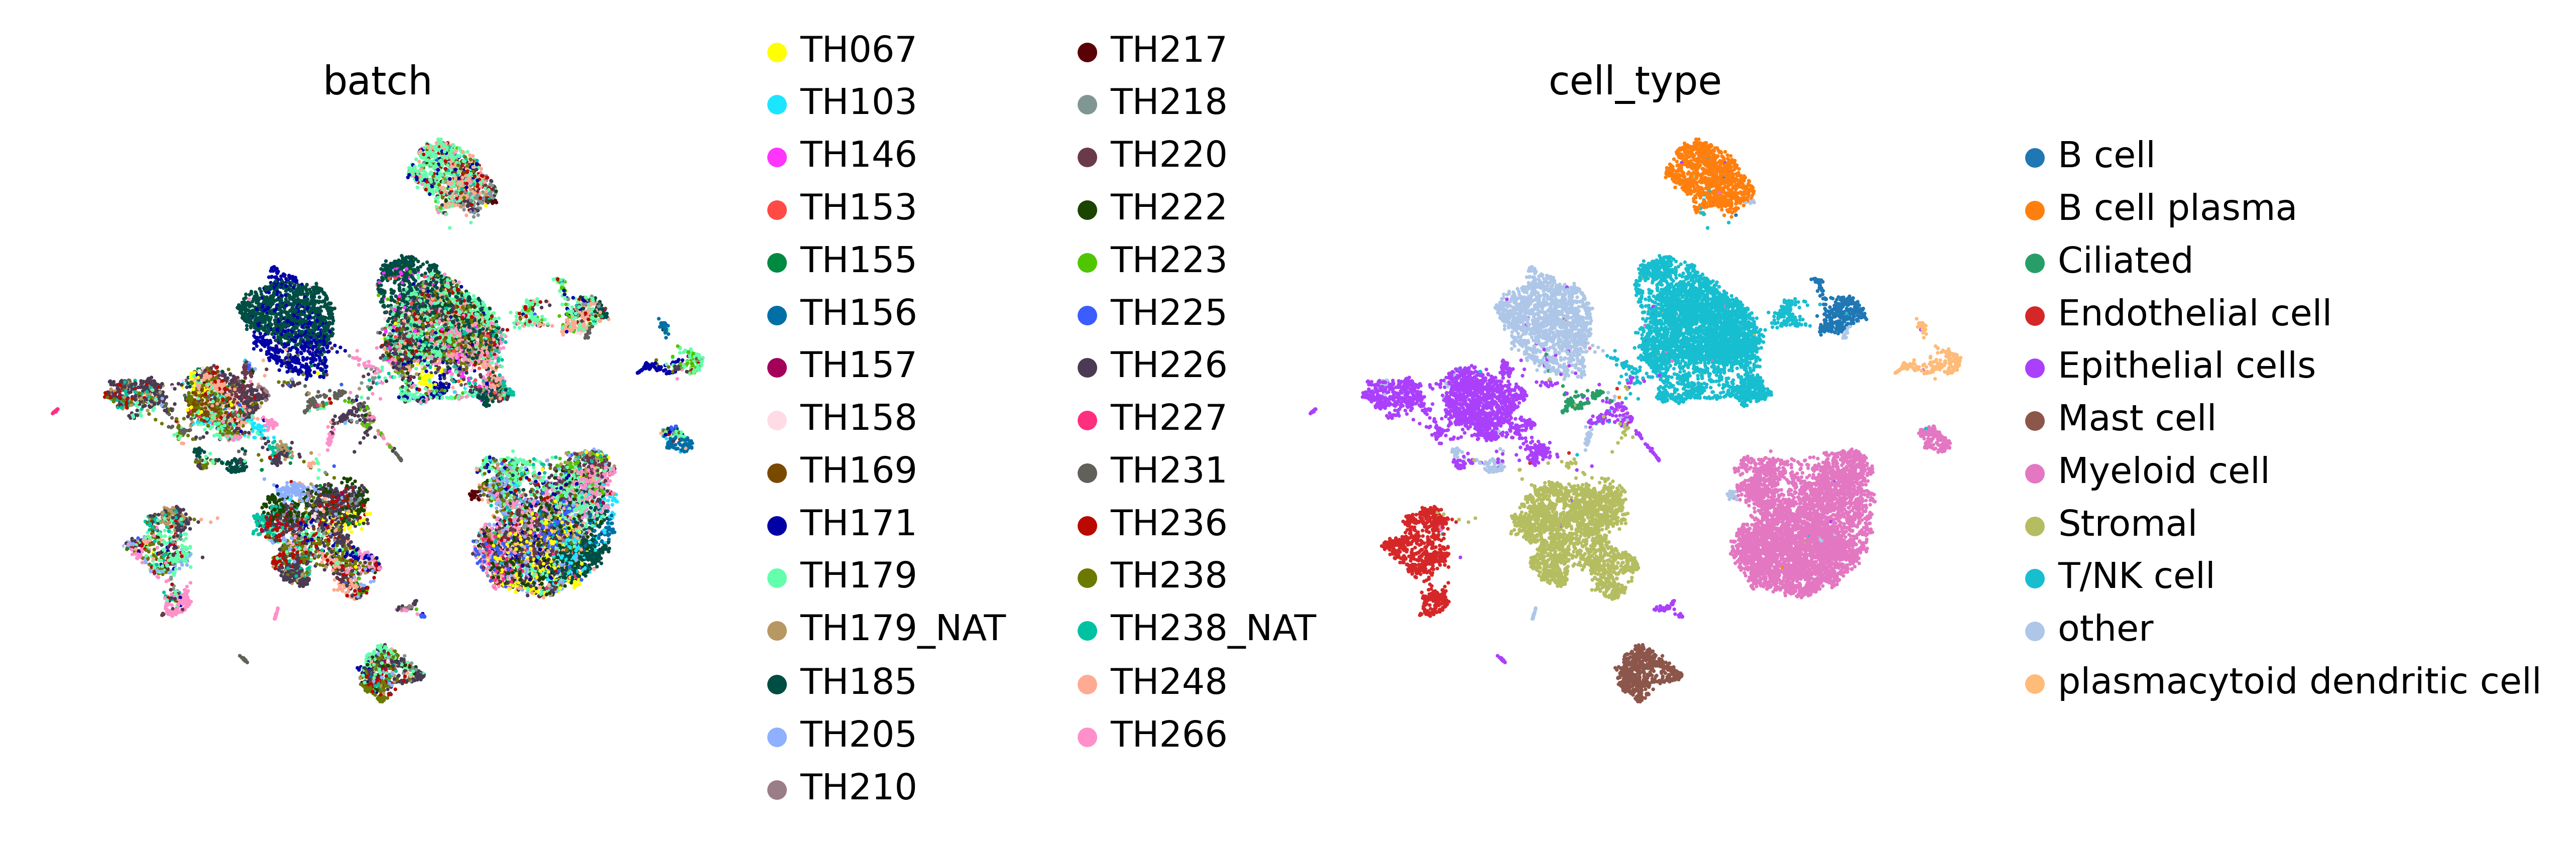

In [27]:
sc.pp.neighbors(reference_latent, n_neighbors=10)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )



In [28]:
reference_latent.obs['predictions'] = vae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
Acc: 0.9794440551273067


In [29]:
reference_latent.uns["predictions_colors"] = reference_latent.uns["cell_type_colors"]

... storing 'predictions' as categorical


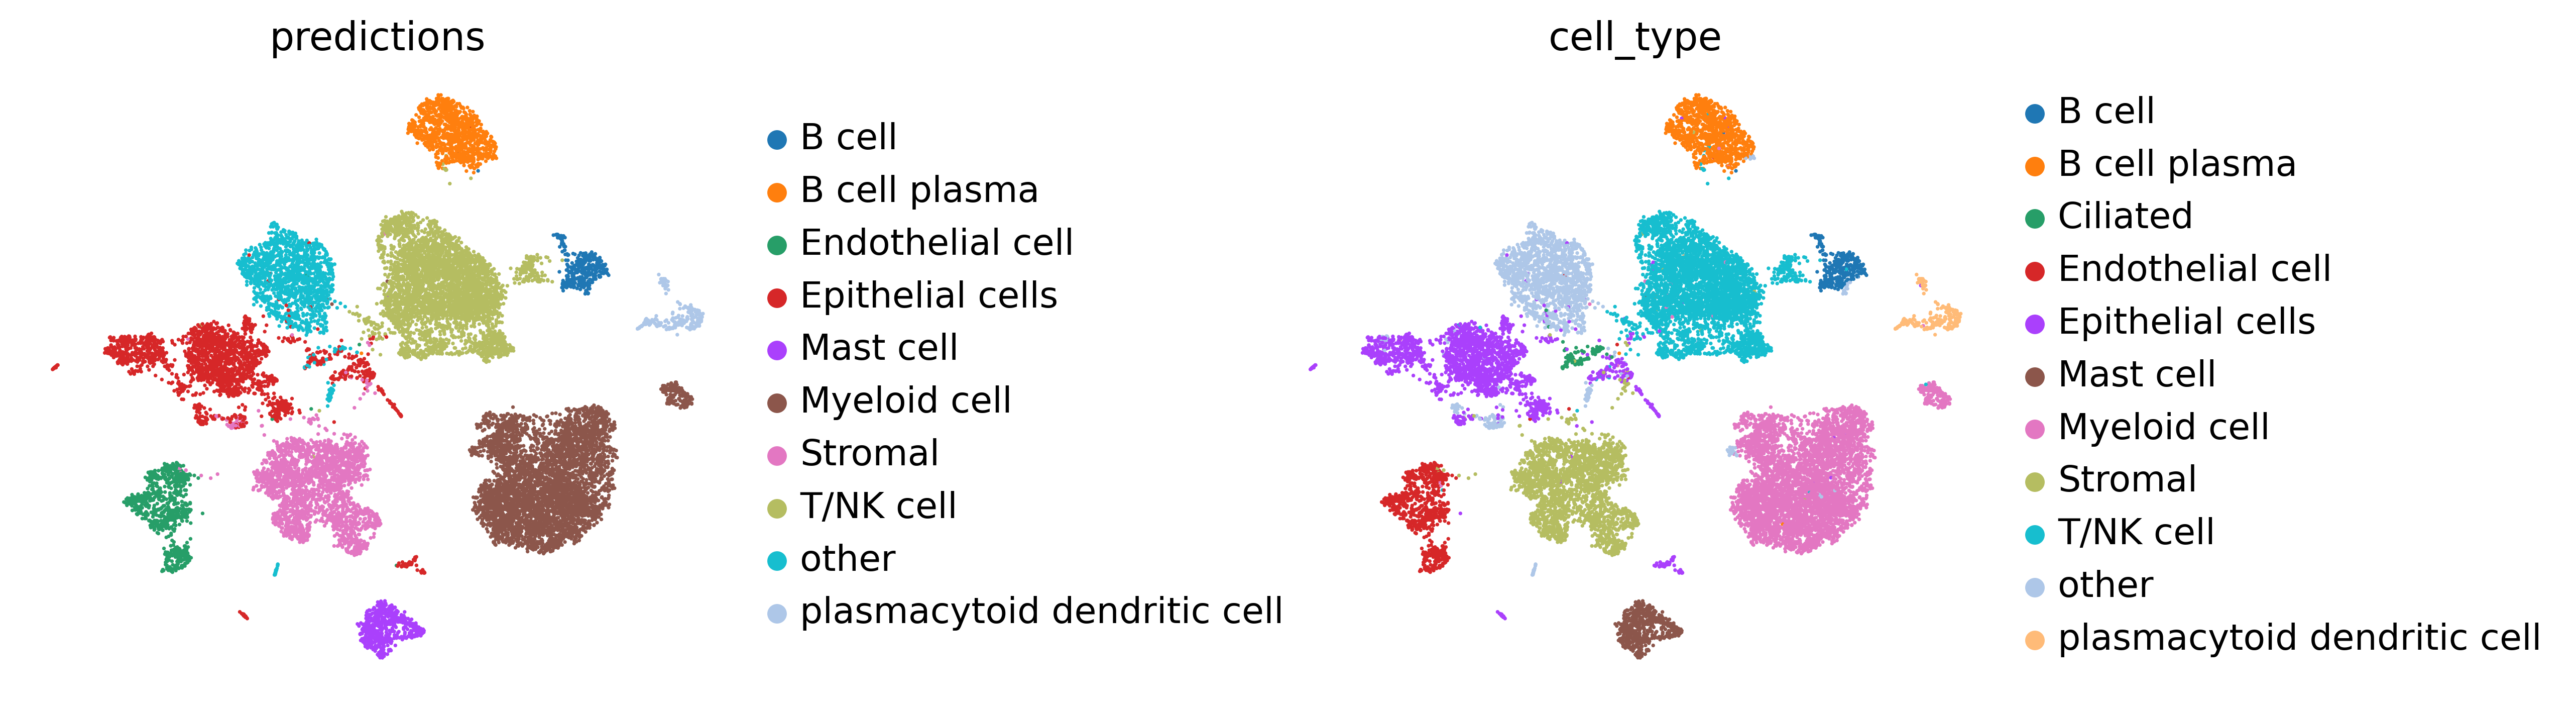

In [30]:
sc.pl.umap(reference_latent,
           color=['predictions', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [31]:
reference_latent.uns.keys()

odict_keys(['neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'predictions_colors'])

In [32]:
ref_path = 'ref_model/'
vae.save(ref_path, overwrite=True)

# prepare query and predict labels

In [33]:
target_adata.obs["cell_type"] = vae.unlabeled_category_

In [34]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 26601 cells, 17974 vars, 56       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
Labelled Indices:  0
Unlabelled Indices:  26601


In [35]:
model.train(
    n_epochs_semisupervised=surgery_epochs,
    train_base_model=False,
    semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"],
                                       weight_decay=0,
                                       early_stopping_kwargs=early_stopping_kwargs_surgery
                                      ),
    frequency=1
)

INFO     Training Unsupervised Trainer for 301 epochs.                                       
INFO     Training SemiSupervised Trainer for 500 epochs.                                     
INFO     KL warmup for 400 epochs                                                            
Training...:  66%|██████▌   | 329/500 [1:10:32<36:23, 12.77s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0.001 nats in 10 epochs                 
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  66%|██████▌   | 329/500 [1:10:45<36:46, 12.90s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  

In [56]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['original_cell_type'] = target_adata.obs["original_cell_type"].tolist()
query_latent.obs['batch'] = target_adata.obs["sample"].tolist()

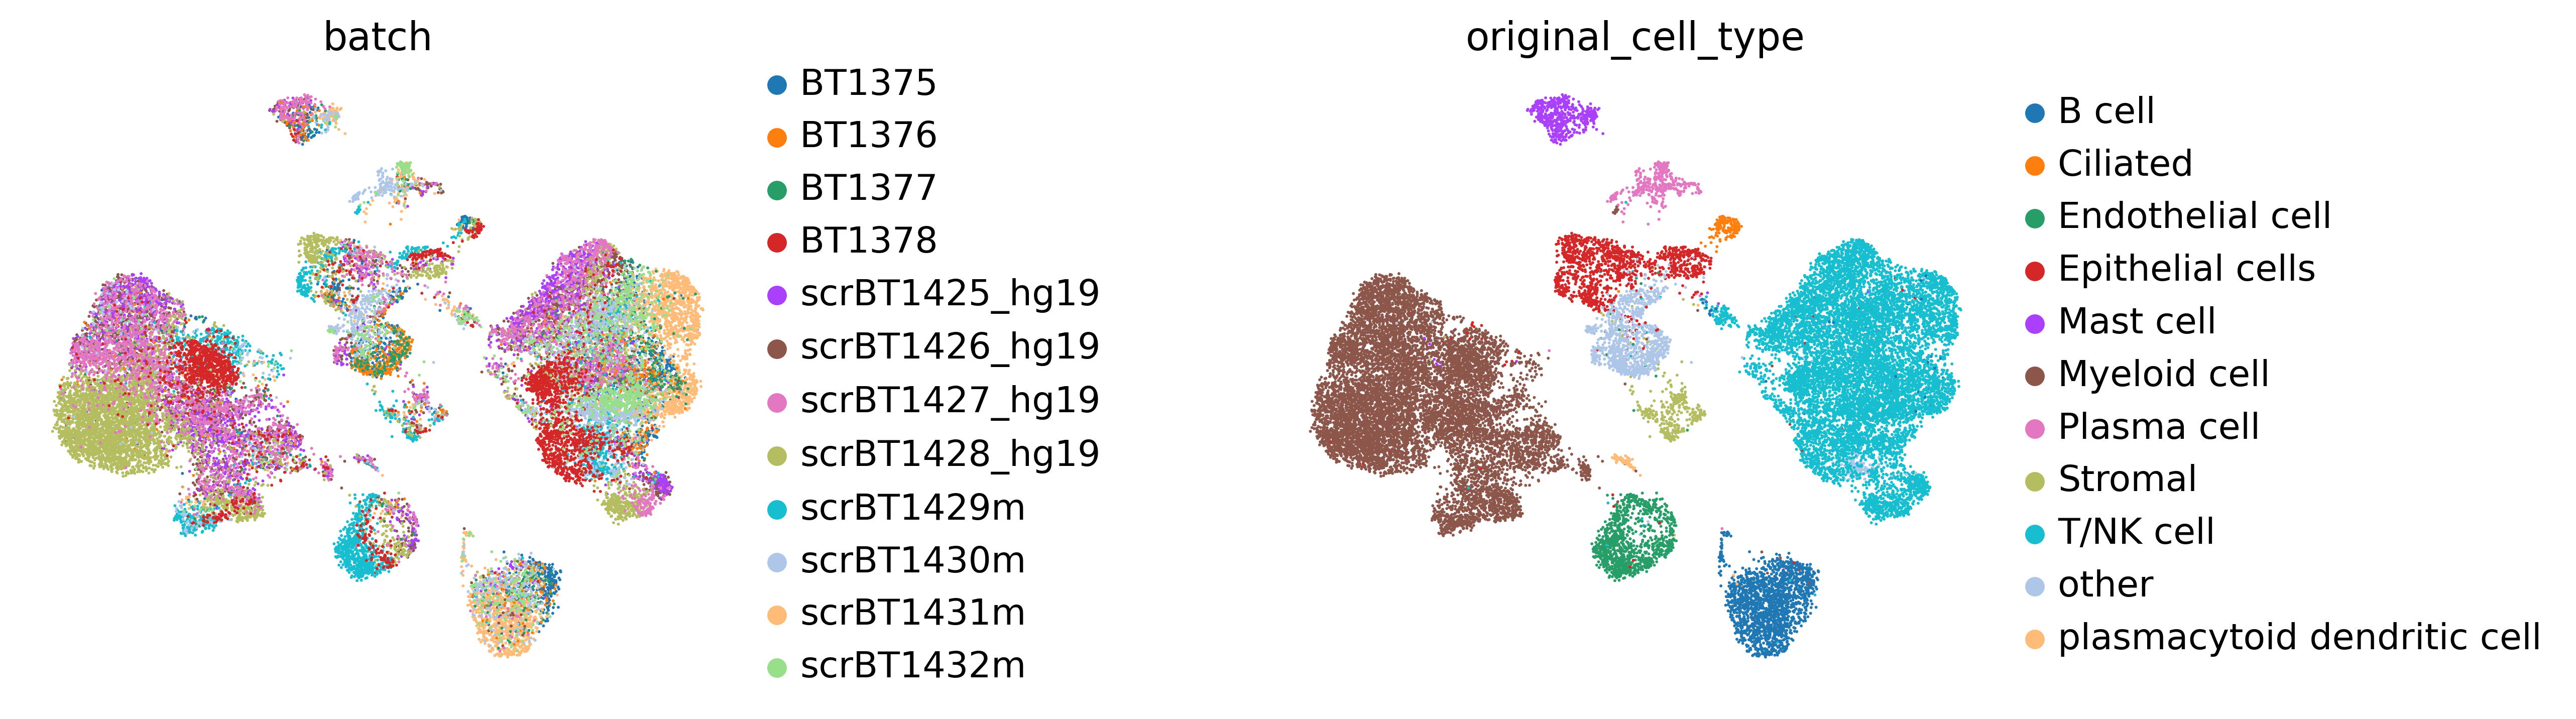

In [59]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
sc.pl.umap(
    query_latent,
    color=["batch", "original_cell_type"],
    frameon=False,
    wspace=0.6,
)


In [60]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)

In [62]:
query_latent.obs['predictions'] = model.predict()
print("Acc: {}".format(np.mean(query_latent.obs["predictions"] == query_latent.obs["original_cell_type"])))

Acc: 0.9094770873275441


... storing 'predictions' as categorical


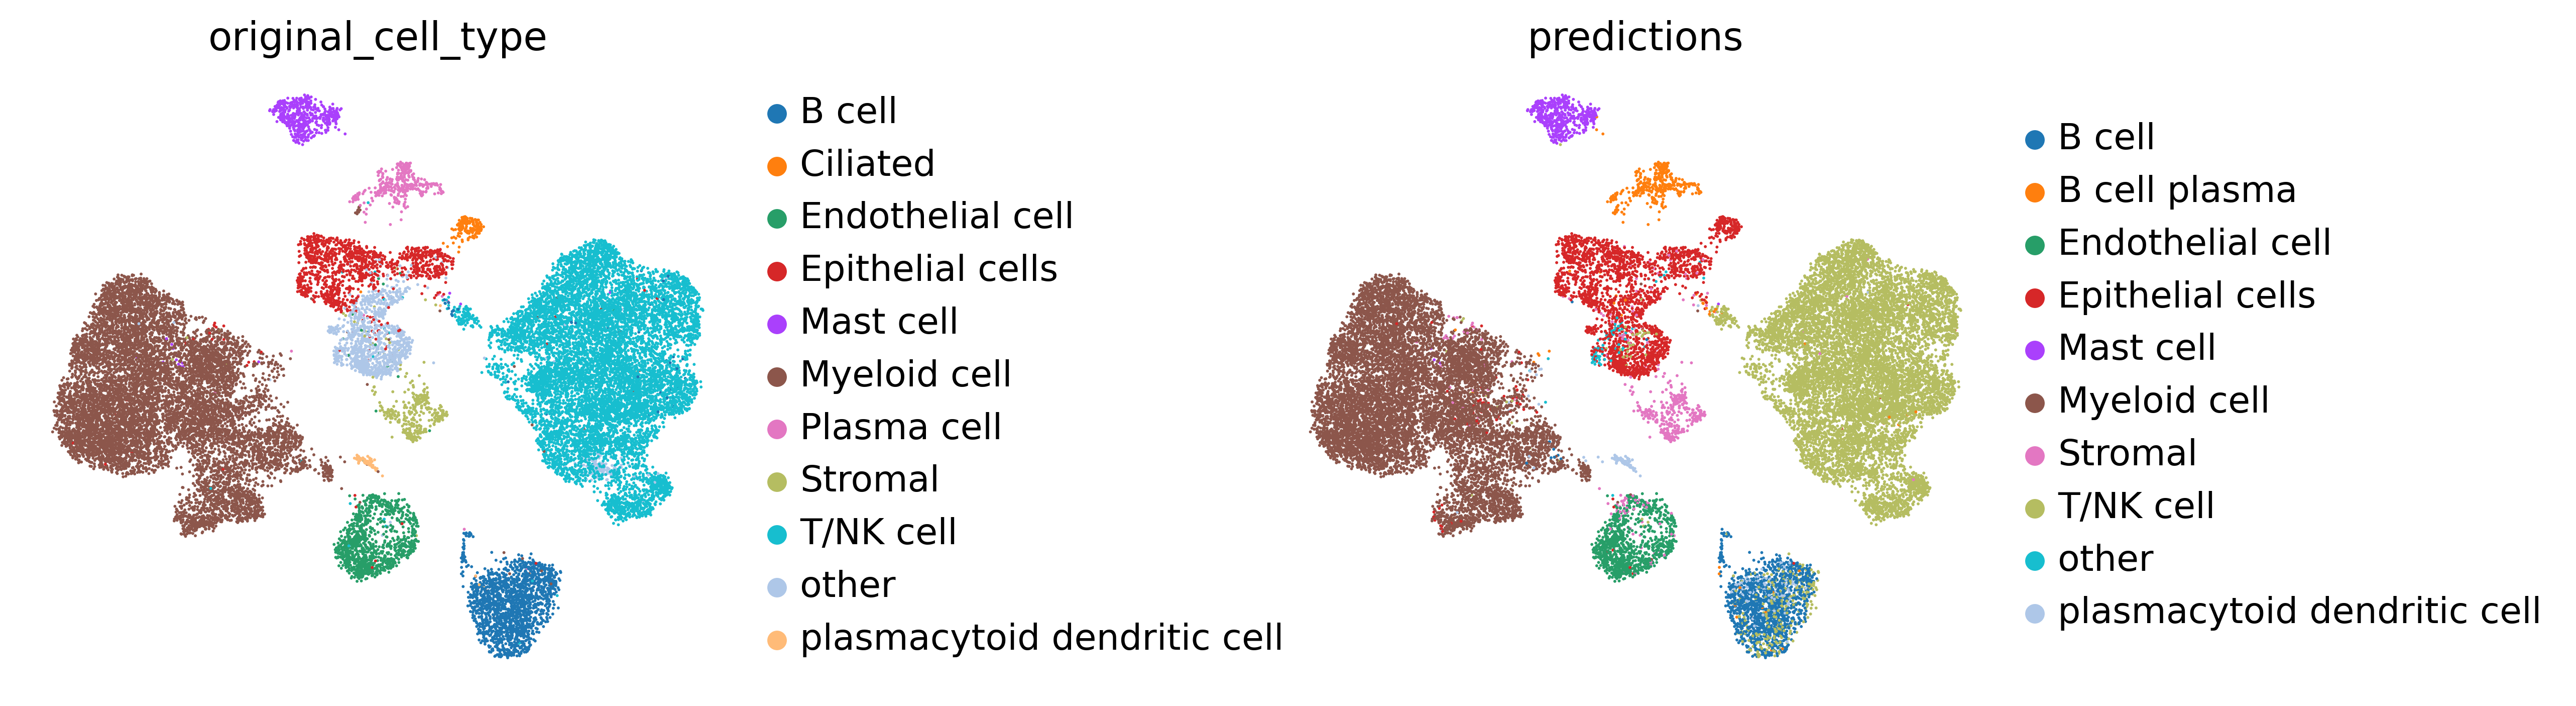

In [63]:
sc.pl.umap(
    query_latent,
    color=["original_cell_type", "predictions"],
    frameon=False,
    wspace=0.6,
)

Text(0, 0.5, 'Observed')

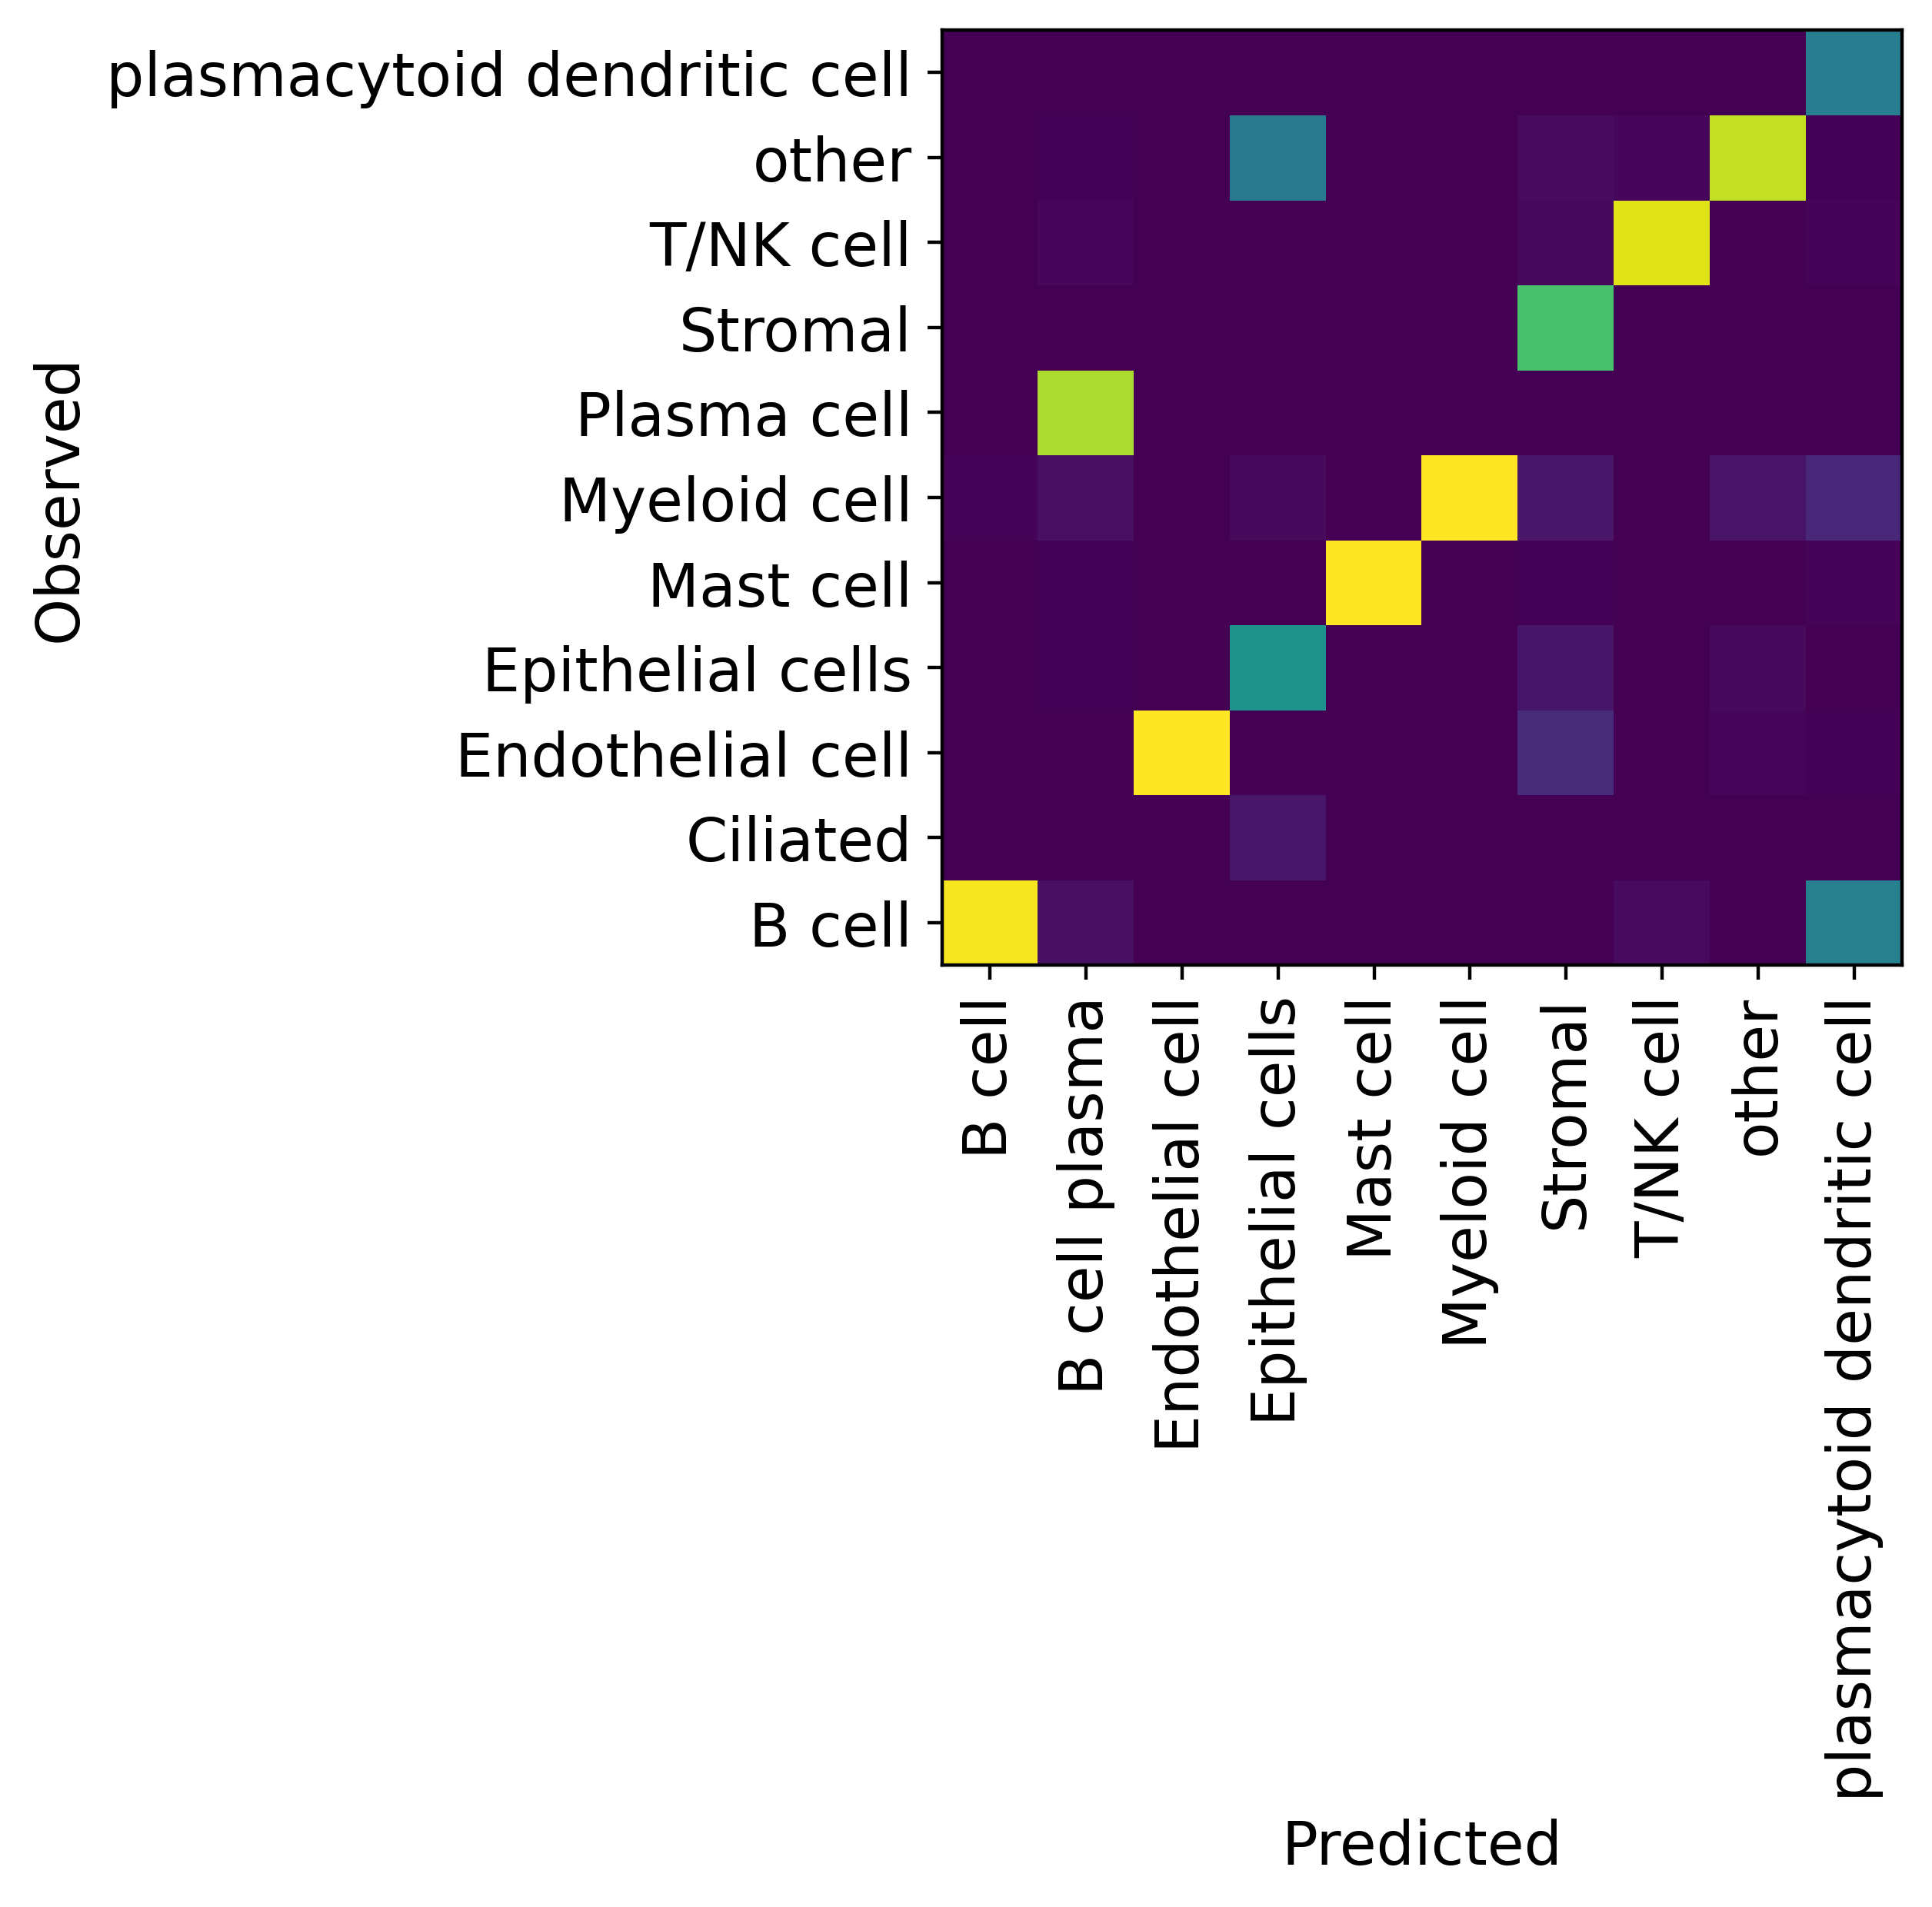

In [67]:
df = query_latent.obs.groupby(["original_cell_type", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(4,4))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

### Get joint latent representation

In [75]:
full_latent = reference_latent.concatenate(query_latent)

In [76]:
full_latent.obs

cell_type batch leiden       predictions original_cell_type
0-0          Myeloid cell     0      3      Myeloid cell                NaN
1-0         B cell plasma     0      6     B cell plasma                NaN
2-0          Myeloid cell     0      3      Myeloid cell                NaN
3-0      Epithelial cells     0      5  Epithelial cells                NaN
4-0                B cell     0     16            B cell                NaN
...                   ...   ...    ...               ...                ...
26596-1               NaN     1      4         T/NK cell          T/NK cell
26597-1               NaN     1      4         T/NK cell          T/NK cell
26598-1               NaN     1      1         T/NK cell          T/NK cell
26599-1               NaN     1      4         T/NK cell          T/NK cell
26600-1               NaN     1     17     B cell plasma        Plasma cell

[43725 rows x 5 columns]

In [74]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['predicted'] = adata_full.obs["predictions"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              


/home/sturm/.conda/envs/pircher-sc-integrate2/lib/python3.8/site-packages/scvi/data/_anndata.py:793: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 43725 cells, 17974 vars, 56       
         batches, 12 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


KeyboardInterrupt: 

In [78]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)


In [82]:
full_latent.obs["cell_type"] = [p if c == "nan" else c for p, c in zip(full_latent.obs["predictions"], full_latent.obs["cell_type"])]

... storing 'cell_type' as categorical


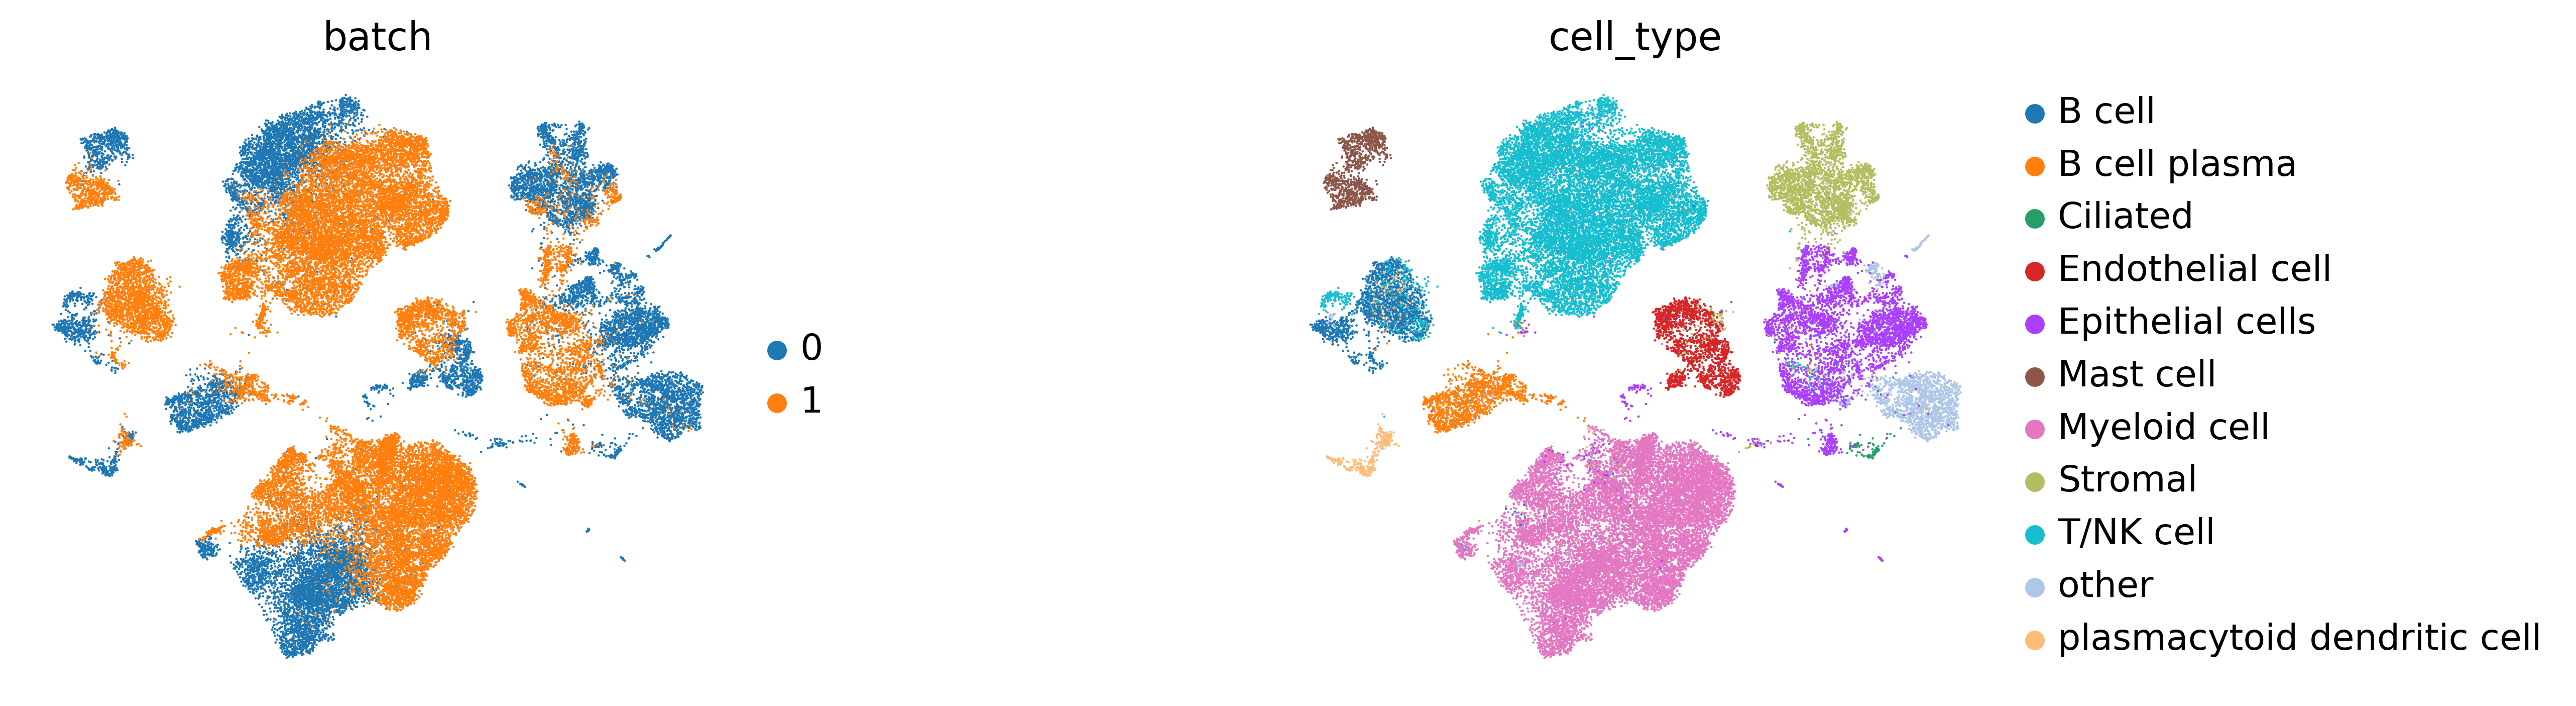

In [83]:
sc.pl.umap(
    full_latent,
    color=["batch","cell_type"],
    frameon=False,
    wspace=0.6,
)

